In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
from utils import fit_pca, test, plot_pca, get_pattern_dataset, train, test
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#configs
epochs = 3
batch_size = 1000
test_batch_size = 10000
use_cuda = True
lr = 1
log_interval = 100
LOAD = True
LOADPATH = 'TinyCNN22:47:04'

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### Train or load an existing MNIST classifier

In [2]:

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    for epoch in tqdm(range(1, epochs + 1)):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
        torch.save(model.state_dict(), model.model_savename())


In [3]:
layers = ['fc2']
layers = ['conv2','fc1', 'fc2']


### Plot the pca projections of activation patterns specified in `layers`

In [4]:
# train_patterns = test(model, device, train_loader, trace=True)
# layers = ['fc2', 'fc3']
# pca = fit_pca(train_patterns, layers)
# plot_pca(model, train_loader, pca, layers)
# plot_pca(model, test_loader, pca, layers)

# indices = dataset1.targets == 8 # if you want to keep images with the label 5
# tmp_dataset = datasets.MNIST('../data', train=True, download=True,
#                           transform=transform)
# tmp_dataset.data, tmp_dataset.targets = tmp_dataset.data[indices], tmp_dataset.targets[indices]
# single_label_loader = torch.utils.data.DataLoader(tmp_dataset, **train_kwargs)
# plot_pca(model, single_label_loader, pca, layers)

# plt.show()


### Create dataset for training the pattern model
First, we create a pos_patterns_dataset and a neg_patterns_dataset. 

Pos_patterns_dataset is generated as follows:
- collect all images of 0, 1, 2, 3, 4
- run them through the trained classifier
- collect all their activation patterns to a set S
- Pos_patterns_dataset is then a set of tuple (pattern, target), in which all targets are 1 (positive), and pattern is in S.

Neg_patterns_dataset is generated in the same way, but images are of 5, 6, 7, 8, 9, and targets are 0 (negative)

The two dataset will then be merged into a training dataset.

In [5]:
positive_labels = [0,1,2,3,4]
negative_labels = [5,6,7,8,9]
#dataset with patterns from 01234, and all labels are 1 (positive)
pos_dataset = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
indices = (pos_dataset.targets == 0) | (pos_dataset.targets == 1) |(pos_dataset.targets == 2) |(pos_dataset.targets == 3) |(pos_dataset.targets == 4) 
pos_dataset.data, pos_dataset.targets = pos_dataset.data[indices], torch.tensor([1]*len(pos_dataset.targets[indices]))

pos_patterns_dataset = get_pattern_dataset(pos_dataset, pos_dataset.targets, model, layers, train_kwargs)

#dataset with patterns from 56789 and all labels are 0 (negative)
neg_dataset = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)

indices = (neg_dataset.targets == 5)|(neg_dataset.targets == 6)|(neg_dataset.targets == 7)|(neg_dataset.targets == 8)|(neg_dataset.targets == 9)
# indices = (neg_dataset.targets == 0)|(neg_dataset.targets == 1)|(neg_dataset.targets == 2)|(neg_dataset.targets == 3)|(neg_dataset.targets == 4)

neg_dataset.data, neg_dataset.targets = neg_dataset.data[indices], torch.tensor([0]*len(neg_dataset.targets[indices]))

neg_patterns_dataset = get_pattern_dataset(neg_dataset, neg_dataset.targets, model, layers, train_kwargs)

#merged 2 dataset
merged_set = torch.utils.data.ConcatDataset([pos_patterns_dataset, neg_patterns_dataset])
merged_loader = torch.utils.data.DataLoader(dataset=merged_set, **train_kwargs) 

#test shape and labels
for idx, (data, target) in enumerate(merged_loader):
    if idx>5: break
    print(data.shape, target[:5])


torch.Size([1000, 4634]) tensor([0, 0, 1, 1, 0])
torch.Size([1000, 4634]) tensor([1, 1, 1, 1, 1])
torch.Size([1000, 4634]) tensor([1, 1, 0, 1, 1])
torch.Size([1000, 4634]) tensor([1, 1, 0, 1, 0])
torch.Size([1000, 4634]) tensor([1, 1, 1, 1, 1])
torch.Size([1000, 4634]) tensor([1, 0, 0, 1, 0])


### Train the pattern classifer

In [49]:
max_unit = 2000
pattern_model = PatternClassifier(4634, max_unit, 2).to(device)
pattern_epochs = 10
optimizer = optim.Adadelta(pattern_model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
for epoch in tqdm(range(1, pattern_epochs + 1)):
    test(pattern_model, device, merged_loader)
    train(pattern_model, device, merged_loader, optimizer, epoch)
    scheduler.step()
    torch.save(pattern_model.state_dict(), pattern_model.model_savename())

  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average loss: 0.7124, Accuracy: 27939/60000 (47%)



 10%|█         | 1/10 [00:03<00:32,  3.66s/it]


Test set: Average loss: 0.3721, Accuracy: 50385/60000 (84%)



 20%|██        | 2/10 [00:07<00:28,  3.61s/it]


Test set: Average loss: 0.2812, Accuracy: 53397/60000 (89%)



 30%|███       | 3/10 [00:10<00:25,  3.61s/it]


Test set: Average loss: 0.2634, Accuracy: 53747/60000 (90%)



 40%|████      | 4/10 [00:14<00:21,  3.61s/it]


Test set: Average loss: 0.2489, Accuracy: 54179/60000 (90%)



 50%|█████     | 5/10 [00:17<00:17,  3.59s/it]


Test set: Average loss: 0.2297, Accuracy: 54746/60000 (91%)



 60%|██████    | 6/10 [00:21<00:14,  3.60s/it]


Test set: Average loss: 0.2272, Accuracy: 54818/60000 (91%)



 70%|███████   | 7/10 [00:24<00:10,  3.49s/it]


Test set: Average loss: 0.2212, Accuracy: 55006/60000 (92%)



 80%|████████  | 8/10 [00:28<00:06,  3.46s/it]


Test set: Average loss: 0.2174, Accuracy: 55071/60000 (92%)



 90%|█████████ | 9/10 [00:31<00:03,  3.47s/it]


Test set: Average loss: 0.2164, Accuracy: 55119/60000 (92%)



100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


### create test pattern dataset
Follow the same logic for train pattern dataset, except we use the MNIST train portion (by setting the flag `train` to False)

In [7]:
pos_test_dataset = datasets.MNIST('../data', train=False, download=True,
                          transform=transform)
indices = (pos_test_dataset.targets == 0) | (pos_test_dataset.targets == 1) |(pos_test_dataset.targets == 2) |(pos_test_dataset.targets == 3) |(pos_test_dataset.targets == 4) 
pos_test_dataset.data, pos_test_dataset.targets = pos_test_dataset.data[indices], torch.tensor([1]*len(pos_test_dataset.targets[indices]))

pos_patterns_test_dataset = get_pattern_dataset(pos_test_dataset, pos_test_dataset.targets, model, layers, train_kwargs)

#dataset with patterns from 56789 and all labels are 0 (negative)
neg_test_dataset = datasets.MNIST('../data', train=False, download=True,
                          transform=transform)

indices = (neg_test_dataset.targets == 5)|(neg_test_dataset.targets == 6)|(neg_test_dataset.targets == 7)|(neg_test_dataset.targets == 8)|(neg_test_dataset.targets == 9)
neg_test_dataset.data, neg_test_dataset.targets = neg_test_dataset.data[indices], torch.tensor([0]*len(neg_test_dataset.targets[indices]))

neg_patterns_test_dataset = get_pattern_dataset(neg_test_dataset, neg_test_dataset.targets, model, layers, train_kwargs)

merged_test_set = torch.utils.data.ConcatDataset([pos_patterns_test_dataset, neg_patterns_test_dataset])
merged_test_loader = torch.utils.data.DataLoader(dataset=merged_test_set, **train_kwargs) 

#### Study the weight of the Pattern Classifier

In [48]:
w = pattern_model.fc1.weight.detach().cpu()
n_unit = w.flatten().shape[0]
print(n_unit)
rec=""
for cap in [0.1, 0.01, 0.001]:
    mask = w.abs() < cap
    print(mask)
    print(mask.sum())
    print(mask.sum().item()/n_unit)
    rec = rec +"& {:.2f}".format(mask.sum().item()/n_unit)
rec = rec + "& {} & {}".format(str(w.abs().max()), str(w.abs().min()))
print(rec)

200
tensor([[ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False,  True,  True,  True, False, False,  True,  True,  True,  True,
          True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True, False, False,  True, False, False, False, False, False,
         False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True, False,  True, False,  True, False,
          True,  True, False,  True, False, False,  True,  True, False, False,
         False,  True,  True,  True,  True, False, False, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False,  True, False,  True, False,  True, False],
        [ True,  True,  True,  True,  True, False,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  Tr

### Test the pattern classifer on the test pattern dataset

In [ ]:
test(pattern_model, device, merged_test_loader)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0]], device='cuda:0')


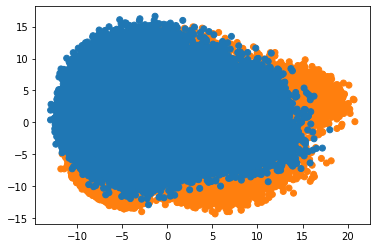

In [8]:
from sklearn.decomposition import PCA
pca = PCA(2)

merged = np.concatenate([pos_patterns_dataset.patterns, neg_patterns_dataset.patterns])
target = np.concatenate([pos_patterns_dataset.targets, neg_patterns_dataset.targets])
Cs = [colors[t] for t in target]

# print(merged.shape)
# print(target)
pca.fit(merged)
Xs=  pca.transform(merged)
plt.figure()
plt.scatter(Xs[:,0], Xs[:,1], c = Cs)

print(pattern_model(torch.tensor(pos_patterns_dataset.patterns[:10]).to(device).float()).argmax(dim=1, keepdim=True))
print(pattern_model(torch.tensor(neg_patterns_dataset.patterns[:10]).to(device).float()).argmax(dim=1, keepdim=True))




In [9]:
# patterns = test(pattern_model, device, merged_test_loader, trace=True)
# pca = fit_pca(patterns, ['fc1'])
# plot_pca(pattern_model, merged_test_loader, pca, ['fc1'])



In [10]:
# pattern_model.fc1(torch.tensor(pos_patterns_dataset.patterns[:10]).to(device).float())

[False False False ... False False False] (2704,)
[False False False ... False False False] (4608,)


<Figure size 1440x1440 with 0 Axes>

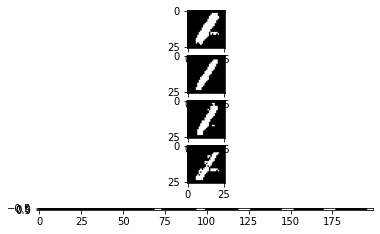

<Figure size 2880x2880 with 0 Axes>

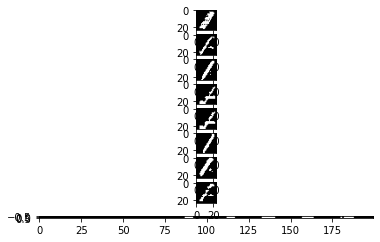

In [11]:

inputs, classes = next(iter(train_loader))
sampled_input = inputs[0]

model.register_log()
model(sampled_input.unsqueeze(0).to(device))
log = copy.deepcopy(model.tensor_log)
model.reset_hooks()

def plot_activation(log):

    print(log['conv1'][0], log['conv1'][0].shape)
    print(log['conv2'][0], log['conv2'][0].shape)

    plt.figure(figsize=(20,20))

    fig, axs = plt.subplots(5)
    for i in range(4):
        axs[i].imshow(log['conv1'].reshape(4, 26, 26)[i], cmap='gray')
    axs[-1].imshow(log['conv1'].reshape(1, 4*26*26)[:,:200], cmap='gray')

    plt.figure(figsize=(40,40))
    fig, axs = plt.subplots(9)

    for i in range(8):
        axs[i].imshow(log['conv2'].reshape(8, 24, 24)[i], cmap='gray')
    axs[-1].imshow(log['conv2'].reshape(1, 8*24*24)[:,:200], cmap='gray')

plot_activation(log)



In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)




accuracies = []
examples = []

# Run test for each epsilon
acc, ex = gen_adv(model, device, test_loader, 0.1)
accuracies.append(acc)



Epsilon: 0.1	Test Accuracy = 6812 / 10000 = 0.6812


5 8
[ True  True  True ... False False False] (2704,)
[False False False ... False False False] (4608,)
[ True  True  True ... False False False] (2704,)
[False False False ... False False False] (4608,)


<Figure size 1440x1440 with 0 Axes>

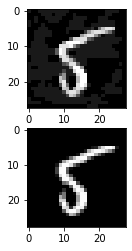

<Figure size 1440x1440 with 0 Axes>

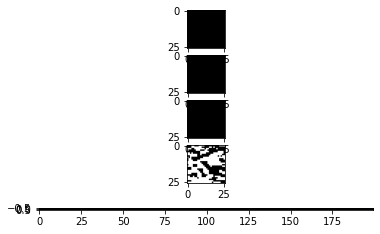

<Figure size 2880x2880 with 0 Axes>

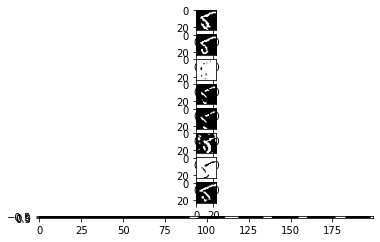

<Figure size 1440x1440 with 0 Axes>

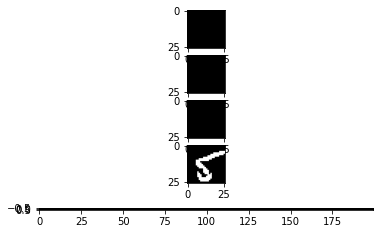

<Figure size 2880x2880 with 0 Axes>

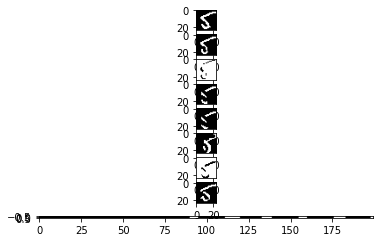

In [13]:
plt.figure(figsize=(20,20))
print(ex[0][0], ex[0][1])
fig, axs = plt.subplots(2)

axs[0].imshow(ex[0][2], cmap='gray')
axs[1].imshow(ex[0][3], cmap='gray')

model.register_log()
model(torch.tensor([[ex[0][2]]]).to(device))
adv_log = copy.deepcopy(model.tensor_log)
model.reset_hooks()

plot_activation(adv_log)

model.register_log()
model(torch.tensor([[ex[0][3]]]).to(device))
ori_log = copy.deepcopy(model.tensor_log)
model.reset_hooks()

plot_activation(ori_log)



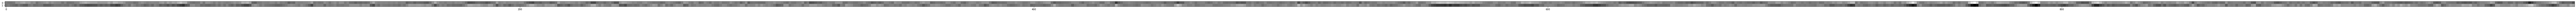

In [17]:
plt.figure(figsize=(200,2))
plt.imshow(pattern_model.fc1.weight.detach().cpu(), cmap = 'gray')
plt.savefig('weight.png')

w = pattern_model.fc1.weight.detach().cpu()


tensor(304)